# Physical Modeling
References:
- https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis
- https://ccrma.stanford.edu/~jos/pasp/Karplus_Strong_Algorithm.html
- https://www.youtube.com/watch?v=Li6OEMCtQ9k


In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from IPython.display import Audio

## The Karplus Strong Algorithm
Made in the late 1960s, maybe the mother of digitally implemented physical modeling. Simulates a string with frequency dependent damping. 
![karplus](img/karplus.png)

This basically 'solves' the 1D Wave equation:

$c\frac{\delta^2 f}{\delta x^2} = \frac{\delta^2f}{\delta t^2}$

Where: 
- $c$ is the speed of sound in the medium (string)
- $f$ is the string position (in $y$ if you will)
- $x$ is just the spacial variable along the string
- $t$ is time in seconds


In [2]:
class KarplusStrong():
    def __init__(self, delayLength):
        self.delayLength = delayLength
        self.buffer = np.zeros(self.delayLength)
        self.z1 = 0
        self.writePosition = 0
        self.readPosition = (self.writePosition-1)%self.delayLength 
    def step(self,x,a):
        yDel = self.buffer[self.readPosition]
        ySum = yDel*0.5+self.z1*0.5
        self.z1 = yDel
        y = ySum
        self.buffer[self.writePosition] = y*a+x
        self.incrementPositions()
        return y
    def incrementPositions(self):
        self.writePosition = (self.writePosition+1)%self.delayLength
        self.readPosition = (self.writePosition+self.delayLength)%(self.delayLength)
        

In [3]:
karpl = KarplusStrong(500)

In [4]:
a = 0.99
N= 300000
inputSig = sig.unit_impulse(N, idx=20)
outPutSig = np.zeros_like(inputSig)
for n in range(N):
    outPutSig[n] = karpl.step(inputSig[n],a)
    

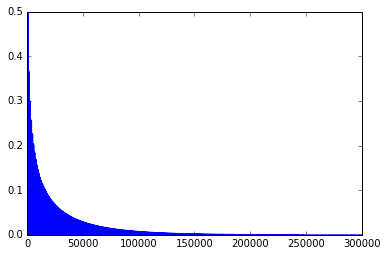

In [5]:
plt.plot(outPutSig)
plt.show()

In [6]:
Audio(data=outPutSig, rate=44100)

/root/miniconda2/envs/findRefrain3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


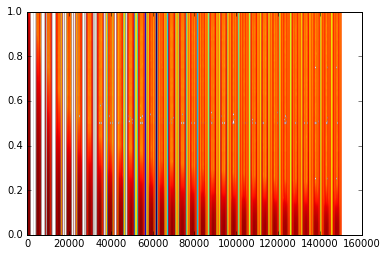

In [7]:
plt.specgram(outPutSig)
plt.show()

## More interesting Exciter
Using a short burst of noise, brings in variation. Filtering this noise can simulate softer excitation of the String.

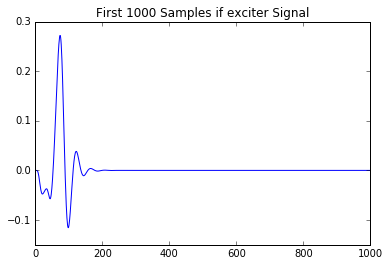

In [8]:
inputSig = (np.random.random(100)-0.5)*2 
inputSig = np.append(inputSig, np.zeros(150000))
lopBa = sig.butter(5,0.05)
inputSig = sig.lfilter(lopBa[0],lopBa[1],inputSig)

plt.plot(inputSig[0:1000])
plt.title("First 1000 Samples if exciter Signal")
plt.show()

In [9]:
a = 0.9
N= len(inputSig)
outPutSig = np.zeros_like(inputSig)
for n in range(N):
    outPutSig[n] = karpl.step(inputSig[n],a)
    

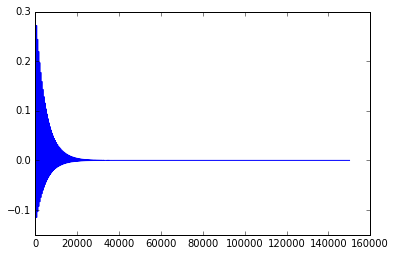

In [10]:
plt.plot(outPutSig)
plt.show()

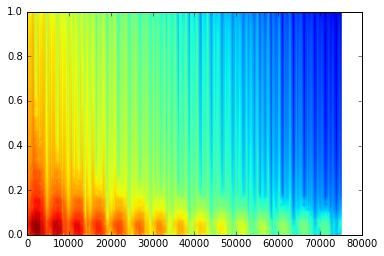

In [11]:
plt.specgram(outPutSig)
plt.show()

In [12]:
Audio(data=outPutSig, rate=44100)

### Simple Karplus in Faust
```
import("stdfaust.lib");

imp = 1<:_,_':-;
delTime = hslider("delTime", 1000,1,44100,1);

fbDel = ((_*0.99:lop),_*0.5:+:de.sdelay(44100,1000,delTime))~_;
lop = _:fi.lowpass(3,2000):_;
process = imp:fbDel;

```

# Modal Modeling
Using a sample of an excited physical body, we analyze it to produce a modal model.

In [2]:
x,sr = librosa.load('/root/Desktop/test_mono.wav',sr=None)

In [3]:
import scipy.signal as sig
import numpy as np

In [12]:
import audio as au

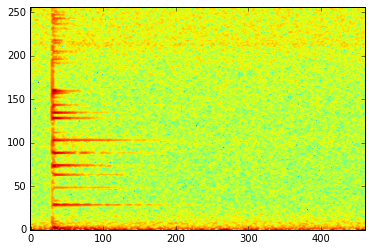

In [24]:
s =  librosa.stft(x,n_fft=512,hop_length=64,win_length=512)

plt.imshow(au.aToDb(abs(s)),aspect='auto',origin=[0,0])
plt.show()

In [27]:
fEnergy = np.mean(abs(s),axis=0)

In [29]:
impulseIndex = np.argmax(fEnergy)

In [30]:
impulseIndex

32

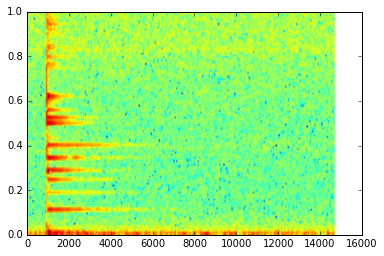

In [16]:
plt.specgram(x)
plt.show()

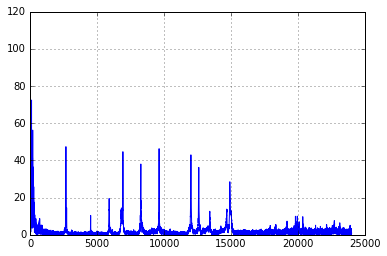

In [16]:
s = np.fft.fft(x)
N = len(s)
halfSpec = s[:int(N/2)]
freqAxis = np.linspace(0,sr/2,len(halfSpec))
plt.plot(freqAxis,abs(halfSpec))
plt.grid()
plt.show()

In [17]:
import peakdetect

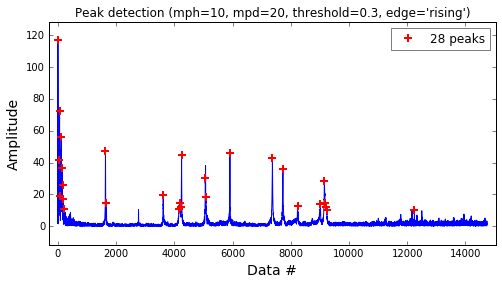

In [18]:
peakIndizes = peakdetect.detect_peaks(abs(halfSpec),mph=10,mpd=20,threshold=.3,show=True)

In [19]:
peakFreqs = (sr/2)*peakIndizes/int(N/2)

In [20]:
np.set_printoptions(suppress=True)

In [21]:
print(peakFreqs)

[     8.14056034     50.47147412     99.31483617    135.13330168
    187.23288786    224.67946544    263.75415508    299.57262058
    341.90353436   2666.84756801   2718.9471542    5895.39379961
   6769.68998033   6812.0208941    6873.8891527    6921.10440269
   8246.38762635   8282.20609185   9623.7704362   11999.18594397
  12586.93440065  13409.13099518  14674.17407232  14905.36598603
  14949.32501187  14991.65592565  15027.47439115  19941.11661353]


In [33]:
peakGains = abs(halfSpec)[peakIndizes]

In [35]:
print (peakGains)

[ 116.85191365   41.84722523   72.44106685   18.80518004   56.29778303
   36.44642138   25.81444206   17.16050521   10.71007237   47.37217411
   14.53476508   19.49497926   10.7152743    14.43157797   12.19046561
   44.66439636   30.53769385   18.24626364   46.28646856   42.97447515
   36.23769661   12.65367237   13.80753351   28.50678887   14.69208911
   12.32846732   10.36995973   10.02910355]


In [23]:
# def tf2s(b2,b1,b0,a1,a0,w1):
#     _ : resonbp(fc,Q,gain) : _

## Faust Reson BP
To build our model, we rebuild faust's Virtual Analog resonant bandpass filter. Here is the FAUST code: 

```
//------------------`(fi.)resonbp`-----------------
// Simple resonant bandpass filters based on `tf2s` (virtual analog).
// `resonbp` is a standard Faust function.
//
// #### Usage
//
// 
// _ : resonlp(fc,Q,gain) : _
// _ : resonhp(fc,Q,gain) : _
// _ : resonbp(fc,Q,gain) : _
//
// 
//
// Where:
//
// * `fc`: center frequency (Hz)
// * `Q`: q
// * `gain`: gain (0-1)
//---------------------------------------------------------------------
// resonbp = 2nd-order bandpass
resonbp(fc,Q,gain) = tf2s(b2,b1,b0,a1,a0,wc)
with {
     wc = 2*ma.PI*fc;
     a1 = 1/Q;
     a0 = 1;
     b2 = 0;
     b1 = gain;
     b0 = 0;
};

```
Where `tf2s` is using a scaled bilinear transform to obtain a digital filter from an analog prototype:

```
tf2(b0,b1,b2,a1,a2) = iir((b0,b1,b2),(a1,a2));

tf2s(b2,b1,b0,a1,a0,w1) = tf2(b0d,b1d,b2d,a1d,a2d)
with {
  c   = 1/tan(w1*0.5/ma.SR); // bilinear-transform scale-factor
  csq = c*c;
  d   = a0 + a1 * c + csq;
  b0d = (b0 + b1 * c + b2 * csq)/d;
  b1d = 2 * (b0 - b2 * csq)/d;
  b2d = (b0 - b1 * c + b2 * csq)/d;
  a1d = 2 * (a0 - csq)/d;
  a2d = (a0 - a1*c + csq)/d;
};

```

In [24]:
def getResonbp(fc,Q,gain,sr):
    """
    Resonating virtual analog Bandpass
    """
    wn = 2*np.pi*fc
    a1 = 1/Q
    a0 = 1
    b2 = 0
    b1 = gain
    b0 = 0
    b0d,b1d,b2d,a1d,a2d = tf2s(b2,b1,b0,a1,a0,wn,sr)
    return [b0d,b1d,b2d],[1,a1d,a2d]
    
    
def tf2s(b2,b1,b0,a1,a0,w1,sr):
    """
    FAUST's Bilinear transform plus frequency scaling (w1)
    """
    c   = 1/np.tan((w1*0.5)/sr); # bilinear-transform scale-factor
    csq = c*c;
    d   = a0 + a1 * c + csq;
    b0d = (b0 + b1 * c + b2 * csq)/d;
    b1d = 2. * (b0 - b2 * csq)/d;
    b2d = (b0 - b1 * c + b2 * csq)/d;
    a1d = 2. * (a0 - csq)/d;
    a2d = (a0 - a1*c + csq)/d;
    return b0d,b1d,b2d,a1d,a2d



In [25]:
testX = sig.unit_impulse(100, idx=10)

In [26]:
# b0d,b1d,b2d,a1d,a2d = tf2s(b2,b1,b0,a1,a0,wn,sr)
# print(b0d,b1d,b2d,a1d,a2d)

bas = getResonbp(100,10,1,44100)
y = sig.lfilter(bas[0],bas[1],testX)


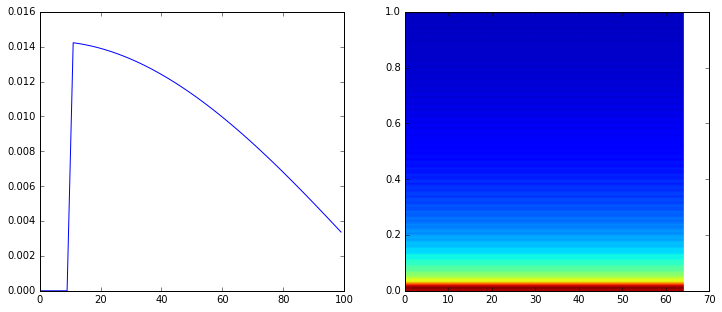

In [27]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(y)
# plt.show()
plt.subplot(122)
plt.specgram(y)
plt.show()

In [28]:
testX = sig.unit_impulse(100000, idx=10000)
Q = 70
y = np.zeros_like(testX)
for freq in peakFreqs:
    thisResonBas = getResonbp(freq,Q,1,sr)
    y = y + sig.lfilter(thisResonBas[0],thisResonBas[1],testX)

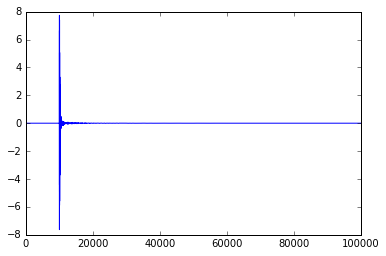

In [29]:
plt.plot(y)
plt.show()

/root/miniconda2/envs/findRefrain3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


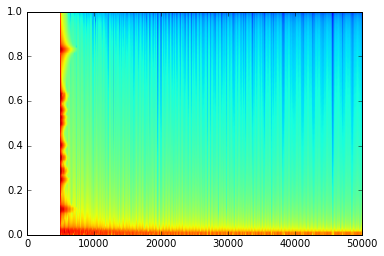

In [30]:
plt.specgram(y)
plt.show()

In [31]:
Audio(data=y,rate=sr)

## Simple Faust Modal model
```

import("stdfaust.lib");
bp(fc,Q) = fi.resonbp(fc,Q,1);




mymodel(Q) = _<:(
  //bp(50.47147412,Q), 
  //bp(99.31483617,Q),
  //bp(135.13330168,Q),
  //bp(224.67946544,Q),
  //bp(263.75415508,Q),
  //bp(299.57262058,Q),
  bp(341.90353436,Q),
  bp(2666.84756801,Q),
  bp( 5895.39379961,Q),
  bp(6921.10440269,Q),
  bp(8282.20609185,Q)
  
  
):>_;

imp = button("gate")<:_,_':-:max(0);
//process = imp;
process = imp:mymodel(70)*20:_;

```

## Automatically Creating a Faust .dsp File

In [32]:
with open('myTest.dsp','w') as f:
    f.write('import("stdfaust.lib");')
    f.write('bp(fc,Q) = fi.resonbp(fc,Q,1);')
    f.write('mymodel(Q) = _<:(')
    for freq in peakFreqs:
        f.write('bp('+str(freq)+',Q),')
    f.write('0')
    f.write('''):>_;

imp = button("gate")<:_,_':-:max(0);
//process = imp;
process = imp:mymodel(70)*20:_;''')
    
        
    